# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [5]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(24),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model_0 = Net().to(device)
summary(model_0, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             100
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 24, 10, 10]           2,160
             ReLU-12           [-1, 24, 10, 10]               0
      BatchNorm2d-13           [-1, 24, 10, 10]              48
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch, L1_Flag =False, L2_Flag = False, alpha = 0 ):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0   
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        #print('y_pred=',len(y_pred.dataset),'target=',len(target.dataset))
        loss = F.nll_loss(y_pred, target)
        #print('loss=',loss)
        
        #Add L1 regularization
        #loss = F.L1loss(y_pred, target)
        #l1_crit=F.L1loss(reduction='sum')
        if L1_Flag or L2_Flag:
          reg_loss = 0
          for p in model.parameters():
            if L1_Flag:
              reg_loss += torch.sum(torch.abs(p.data))
            if L2_Flag:
              reg_loss += torch.sum(p.data.pow(2))
          #for p in model.parameters():
            #l1_l2_reg_loss += torch.abs(p.data)+p.data.pow(2)
          loss+= (alpha*reg_loss)

        tr_ls = loss
        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm 
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        tr_ac = (100*correct/processed)
    return tr_ls, tr_ac

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    ts_ls = test_loss

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    ts_ac = (100. * correct / len(test_loader.dataset))

    return ts_ls, ts_ac

      
    

# Finding Misclassified Images

In [0]:
#Let's visualize the images
%matplotlib inline
import matplotlib.pyplot as plt

def miscImages(model, device, test_loader):
    model.eval()
    test_loss = 0
    incorrect = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

            for i in range(len(target)):
              if pred[i].item() != target[i]:
                incorrect += 1
                print('\n\n{} [ Predicted Value: {}, Actual Value: {} ]'.format(
                incorrect, pred[i].item(), target[i], ))
                plt.imshow(data[i].cpu().numpy().squeeze(), cmap='gray_r')
                plt.show()




#Plot Losses and Accuracies

In [0]:
import matplotlib.pyplot as plt 


def plotGraphsTest(test_losses_0, test_losses_l1, test_losses_l2, test_losses_l1_l2, test_acc_0, test_acc_l1, test_acc_l2, test_acc_l1_l2):
  fig, axs = plt.subplots(2,1,figsize=(30,15))
  axs[0].plot(test_losses_0,color='black',label='without l1,l2')
  axs[0].plot(test_losses_l1,color='red',label='with l1 ')
  axs[0].plot(test_losses_l2,color='blue',label='with l2')
  axs[0].plot(test_losses_l1_l2,color='green',label='with l1 and l2')
  axs[0].set_title("Validation Loss Change")
  axs[0].legend(loc="upper right")

  axs[1].plot(test_acc_0,color='black',label='without l1,l2')
  axs[1].plot(test_acc_l1,color='red',label='with l1 ')
  axs[1].plot(test_acc_l2,color='blue',label='with l2 ')
  axs[1].plot(test_acc_l1_l2,color='green',label='with l1 and l2')
  axs[1].set_title("Validation Accuracy Change")
  axs[1].legend(loc="lower right")
  plt.show()

def plotGraphsTrain(train_losses_0, train_losses_l1, train_losses_l2, train_losses_l1_l2, train_acc_0, train_acc_l1, train_acc_l2, train_acc_l1_l2):
  fig, axs = plt.subplots(2,1,figsize=(30,15))
  axs[0].plot(test_losses_0,color='black',label='without l1,l2')
  axs[0].plot(test_losses_l1,color='red',label='with l1 ')
  axs[0].plot(test_losses_l2,color='blue',label='with l2')
  axs[0].plot(test_losses_l1_l2,color='green',label='with l1 and l2')
  axs[0].set_title("Training Loss Change")
  axs[0].legend(loc="upper right")

  axs[1].plot(test_acc_0,color='black',label='without l1,l2')
  axs[1].plot(test_acc_l1,color='red',label='with l1 ')
  axs[1].plot(test_acc_l2,color='blue',label='with l2 ')
  axs[1].plot(test_acc_l1_l2,color='green',label='with l1 and l2')
  axs[1].set_title("Training Accuracy Change")
  axs[1].legend(loc="lower right")
  plt.show()

# Let's Train and test our model

In [0]:
from torch.optim.lr_scheduler import StepLR
def trainModel(label,L1_Flag =False, L2_Flag = False, alpha = 0 ):
  EPOCHS = 40
  model_0 = Net().to(device)
  optimizer = optim.SGD(model_0.parameters(), lr=0.01, momentum=0.95)
  scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
  print("alpha = ",alpha)
  train_losses = []
  train_acc    = []
  test_losses = []
  test_acc  = []
  for epoch in range(EPOCHS):
      print("EPOCH",label, epoch)
      tr_ls, tr_ac = train(model_0, device, train_loader, optimizer, epoch, L1_Flag, L2_Flag, alpha)
      ts_ls, ts_ac = test(model_0, device, test_loader)
      train_losses.append(tr_ls)
      train_acc.append(tr_ac)
      test_losses.append(ts_ls)
      test_acc.append(ts_ac)
  print('\n@@@@@@@@@@@@@MISCLASSIFIED IMAGES@@@@@@@@@@@@@@@@@@@@@@@@@@@\n')
  miscImages(model_0, device, test_loader)
  return train_losses, train_acc, test_losses, test_acc

#Lambda = 0.00005

In [0]:
al = 0.00005  

        

#Without L1 and L2 Optimisations

  0%|          | 0/469 [00:00<?, ?it/s]


********************************For lambda = 5e-05************************************


#########################Without L1 and L2 Optimisations###########################

alpha =  0
EPOCH _0 0


Loss=0.09806867688894272 Batch_id=468 Accuracy=88.17: 100%|██████████| 469/469 [00:13<00:00, 35.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0726, Accuracy: 9772/10000 (97.72%)

EPOCH _0 1


Loss=0.08447495102882385 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:13<00:00, 34.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0476, Accuracy: 9836/10000 (98.36%)

EPOCH _0 2


Loss=0.058298613876104355 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:13<00:00, 34.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0428, Accuracy: 9875/10000 (98.75%)

EPOCH _0 3


Loss=0.039254482835531235 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:13<00:00, 34.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9906/10000 (99.06%)

EPOCH _0 4


Loss=0.02757192589342594 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:13<00:00, 35.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9911/10000 (99.11%)

EPOCH _0 5


Loss=0.012364516966044903 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:13<00:00, 38.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9907/10000 (99.07%)

EPOCH _0 6


Loss=0.021817520260810852 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:13<00:00, 33.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9898/10000 (98.98%)

EPOCH _0 7


Loss=0.04945607855916023 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:14<00:00, 32.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9921/10000 (99.21%)

EPOCH _0 8


Loss=0.012432347051799297 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:14<00:00, 33.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9914/10000 (99.14%)

EPOCH _0 9


Loss=0.04366341605782509 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:13<00:00, 34.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9930/10000 (99.30%)

EPOCH _0 10


Loss=0.06577941030263901 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:13<00:00, 34.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9914/10000 (99.14%)

EPOCH _0 11


Loss=0.010836024768650532 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:13<00:00, 34.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9929/10000 (99.29%)

EPOCH _0 12


Loss=0.09707126021385193 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:14<00:00, 33.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9940/10000 (99.40%)

EPOCH _0 13


Loss=0.10519707202911377 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:13<00:00, 34.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9942/10000 (99.42%)

EPOCH _0 14


Loss=0.042324602603912354 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 33.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9931/10000 (99.31%)

EPOCH _0 15


Loss=0.0038946818094700575 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:14<00:00, 33.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9927/10000 (99.27%)

EPOCH _0 16


Loss=0.08194147050380707 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:14<00:00, 32.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9918/10000 (99.18%)

EPOCH _0 17


Loss=0.015271641314029694 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:14<00:00, 37.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9923/10000 (99.23%)

EPOCH _0 18


Loss=0.0076478817500174046 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:14<00:00, 32.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9933/10000 (99.33%)

EPOCH _0 19


Loss=0.07041627913713455 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:14<00:00, 32.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9922/10000 (99.22%)

EPOCH _0 20


Loss=0.0016422569751739502 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:14<00:00, 33.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9937/10000 (99.37%)

EPOCH _0 21


Loss=0.043218668550252914 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:14<00:00, 32.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9929/10000 (99.29%)

EPOCH _0 22


Loss=0.007280141115188599 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:14<00:00, 40.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9938/10000 (99.38%)

EPOCH _0 23


Loss=0.01308200228959322 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:14<00:00, 32.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9935/10000 (99.35%)

EPOCH _0 24


Loss=0.0616881437599659 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:14<00:00, 32.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9935/10000 (99.35%)

EPOCH _0 25


Loss=0.05377189815044403 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 32.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9928/10000 (99.28%)

EPOCH _0 26


Loss=0.003739307401701808 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 34.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9928/10000 (99.28%)

EPOCH _0 27


Loss=0.01920974813401699 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 33.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9923/10000 (99.23%)

EPOCH _0 28


Loss=0.0067176916636526585 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 34.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9928/10000 (99.28%)

EPOCH _0 29


Loss=0.0074509731493890285 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 33.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9944/10000 (99.44%)

EPOCH _0 30


Loss=0.009216810576617718 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:13<00:00, 33.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9939/10000 (99.39%)

EPOCH _0 31


Loss=0.008338481187820435 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 34.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9938/10000 (99.38%)

EPOCH _0 32


Loss=0.03506327047944069 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 41.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9938/10000 (99.38%)

EPOCH _0 33


Loss=0.02248651348054409 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:13<00:00, 34.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9934/10000 (99.34%)

EPOCH _0 34


Loss=0.032311927527189255 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 34.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9944/10000 (99.44%)

EPOCH _0 35


Loss=0.0032626937609165907 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:13<00:00, 35.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9929/10000 (99.29%)

EPOCH _0 36


Loss=0.004679197911173105 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 35.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9934/10000 (99.34%)

EPOCH _0 37


Loss=0.017403578385710716 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 34.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9932/10000 (99.32%)

EPOCH _0 38


Loss=0.033895980566740036 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:12<00:00, 36.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9936/10000 (99.36%)

EPOCH _0 39


Loss=0.0021373629570007324 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:13<00:00, 35.39it/s]



Test set: Average loss: 0.0177, Accuracy: 9936/10000 (99.36%)


@@@@@@@@@@@@@MISCLASSIFIED IMAGES@@@@@@@@@@@@@@@@@@@@@@@@@@@



1 [ Predicted Value: 7, Actual Value: 2 ]


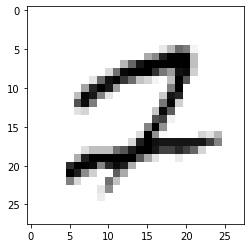



2 [ Predicted Value: 1, Actual Value: 7 ]


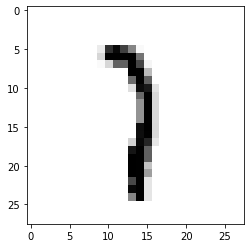



3 [ Predicted Value: 1, Actual Value: 7 ]


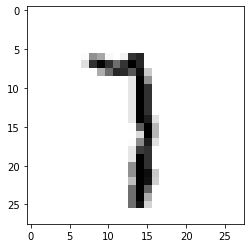



4 [ Predicted Value: 1, Actual Value: 7 ]


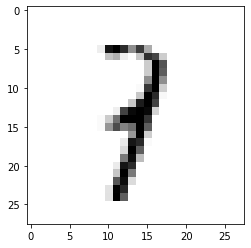



5 [ Predicted Value: 7, Actual Value: 0 ]


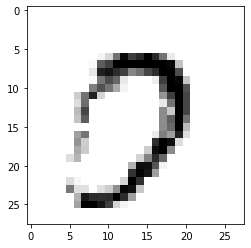



6 [ Predicted Value: 6, Actual Value: 2 ]


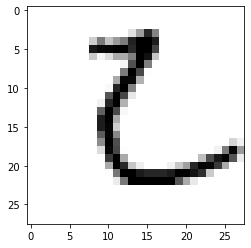



7 [ Predicted Value: 2, Actual Value: 1 ]


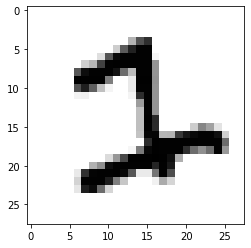



8 [ Predicted Value: 1, Actual Value: 7 ]


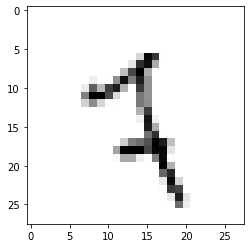



9 [ Predicted Value: 7, Actual Value: 8 ]


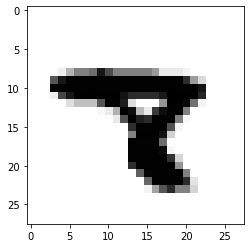



10 [ Predicted Value: 8, Actual Value: 6 ]


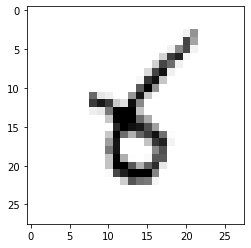



11 [ Predicted Value: 2, Actual Value: 8 ]


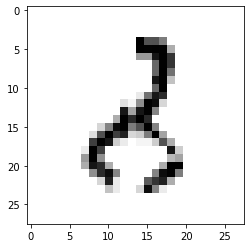



12 [ Predicted Value: 9, Actual Value: 4 ]


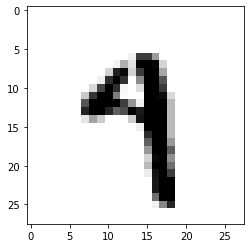



13 [ Predicted Value: 3, Actual Value: 5 ]


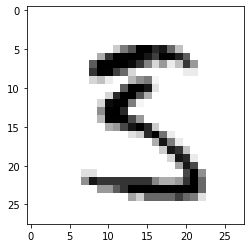



14 [ Predicted Value: 3, Actual Value: 8 ]


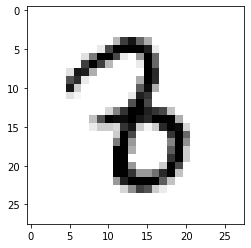



15 [ Predicted Value: 0, Actual Value: 6 ]


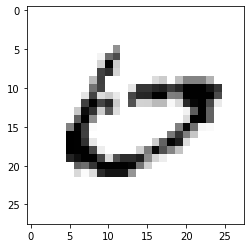



16 [ Predicted Value: 6, Actual Value: 1 ]


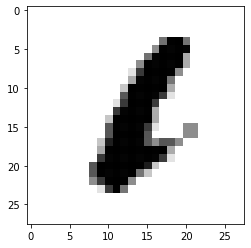



17 [ Predicted Value: 1, Actual Value: 8 ]


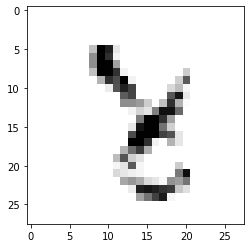



18 [ Predicted Value: 7, Actual Value: 3 ]


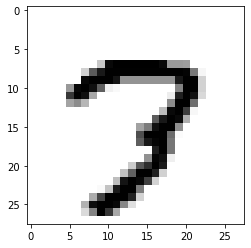



19 [ Predicted Value: 7, Actual Value: 2 ]


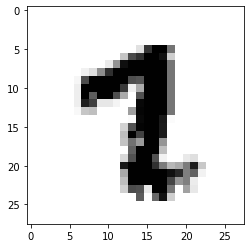



20 [ Predicted Value: 3, Actual Value: 5 ]


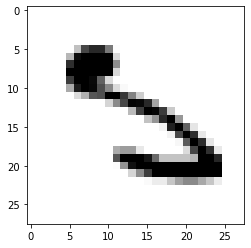



21 [ Predicted Value: 9, Actual Value: 4 ]


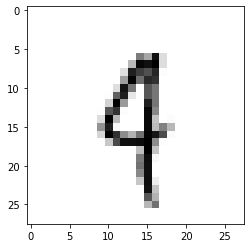



22 [ Predicted Value: 1, Actual Value: 7 ]


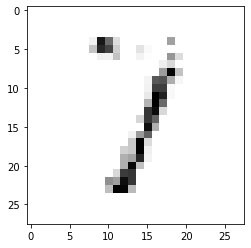



23 [ Predicted Value: 9, Actual Value: 4 ]


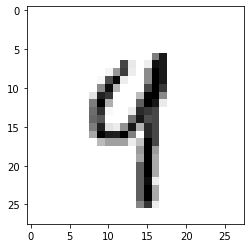



24 [ Predicted Value: 0, Actual Value: 6 ]


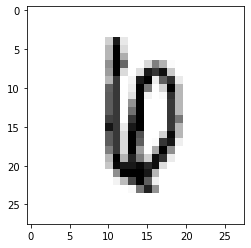



25 [ Predicted Value: 0, Actual Value: 8 ]


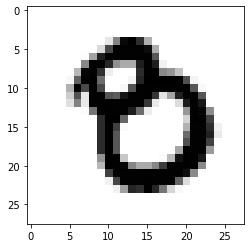



26 [ Predicted Value: 9, Actual Value: 8 ]


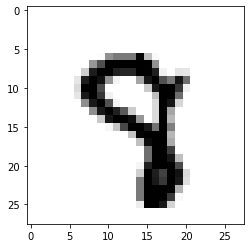



27 [ Predicted Value: 1, Actual Value: 7 ]


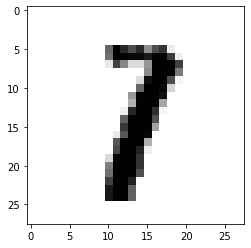



28 [ Predicted Value: 9, Actual Value: 4 ]


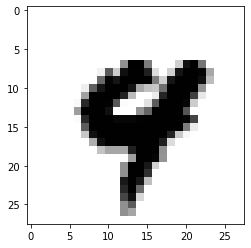



29 [ Predicted Value: 9, Actual Value: 4 ]


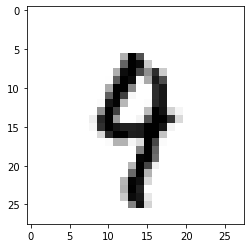



30 [ Predicted Value: 9, Actual Value: 8 ]


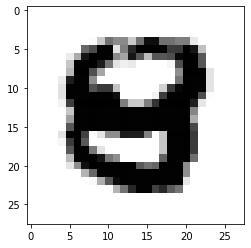



31 [ Predicted Value: 6, Actual Value: 5 ]


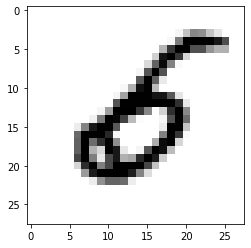



32 [ Predicted Value: 1, Actual Value: 6 ]


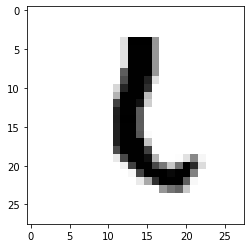



33 [ Predicted Value: 2, Actual Value: 7 ]


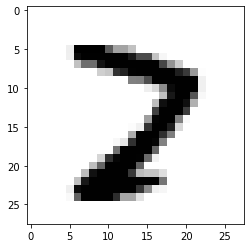



34 [ Predicted Value: 9, Actual Value: 4 ]


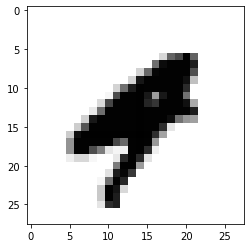



35 [ Predicted Value: 2, Actual Value: 7 ]


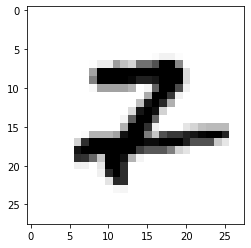



36 [ Predicted Value: 6, Actual Value: 2 ]


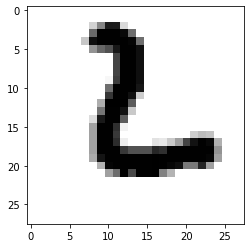



37 [ Predicted Value: 3, Actual Value: 5 ]


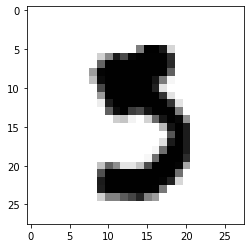



38 [ Predicted Value: 3, Actual Value: 5 ]


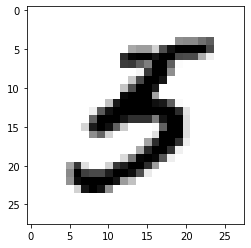



39 [ Predicted Value: 0, Actual Value: 6 ]


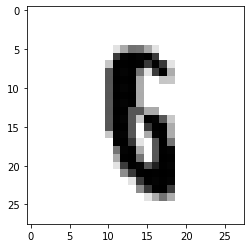



40 [ Predicted Value: 6, Actual Value: 2 ]


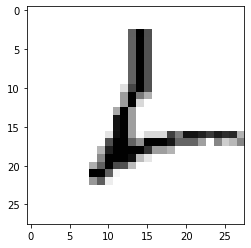



41 [ Predicted Value: 4, Actual Value: 9 ]


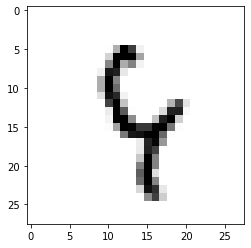



42 [ Predicted Value: 0, Actual Value: 6 ]


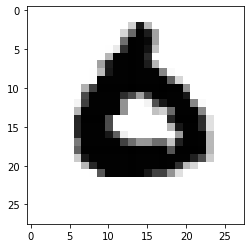



43 [ Predicted Value: 9, Actual Value: 4 ]


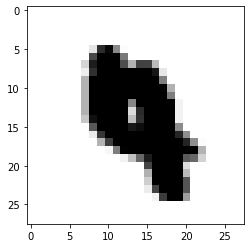



44 [ Predicted Value: 9, Actual Value: 4 ]


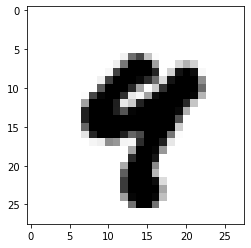



45 [ Predicted Value: 6, Actual Value: 5 ]


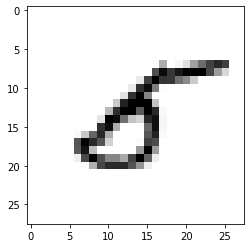



46 [ Predicted Value: 2, Actual Value: 7 ]


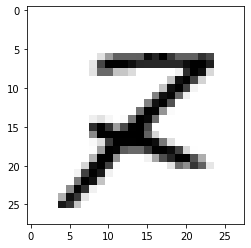



47 [ Predicted Value: 5, Actual Value: 6 ]


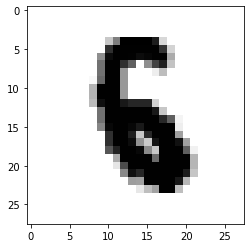



48 [ Predicted Value: 9, Actual Value: 8 ]


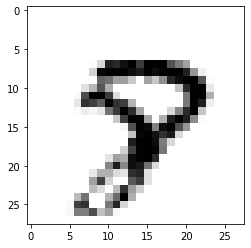



49 [ Predicted Value: 3, Actual Value: 7 ]


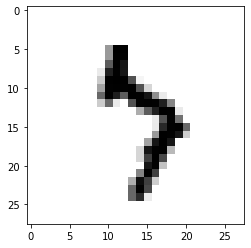



50 [ Predicted Value: 7, Actual Value: 2 ]


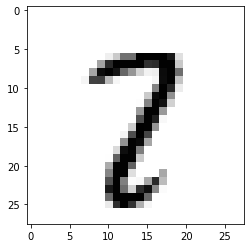



51 [ Predicted Value: 9, Actual Value: 8 ]


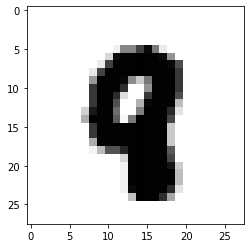



52 [ Predicted Value: 2, Actual Value: 7 ]


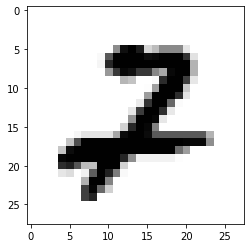



53 [ Predicted Value: 6, Actual Value: 2 ]


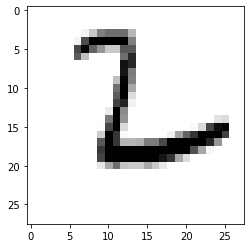



54 [ Predicted Value: 5, Actual Value: 6 ]


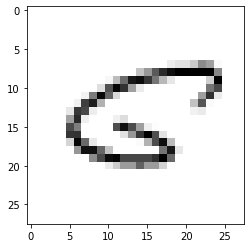



55 [ Predicted Value: 3, Actual Value: 2 ]


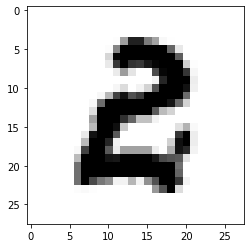



56 [ Predicted Value: 5, Actual Value: 8 ]


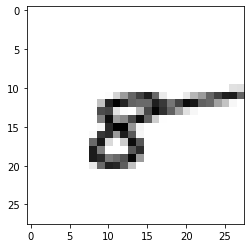



57 [ Predicted Value: 1, Actual Value: 6 ]


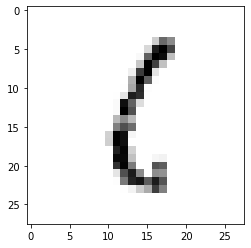



58 [ Predicted Value: 1, Actual Value: 6 ]


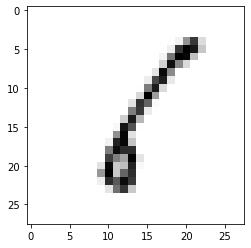



59 [ Predicted Value: 0, Actual Value: 2 ]


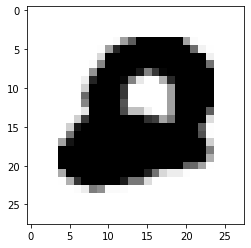



60 [ Predicted Value: 4, Actual Value: 9 ]


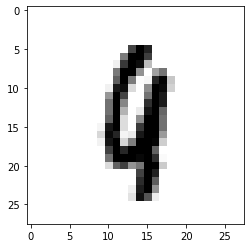



61 [ Predicted Value: 4, Actual Value: 9 ]


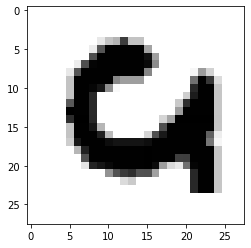



62 [ Predicted Value: 5, Actual Value: 3 ]


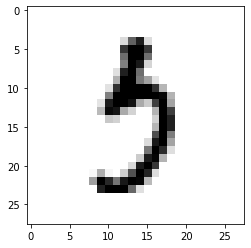



63 [ Predicted Value: 4, Actual Value: 7 ]


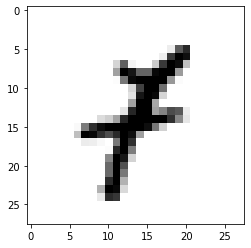



64 [ Predicted Value: 7, Actual Value: 2 ]


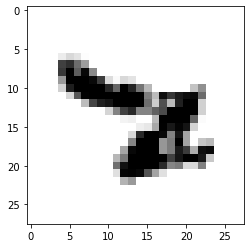

In [14]:
  print('\n********************************For lambda = {}************************************\n'.format(al))
  print('\n#########################Without L1 and L2 Optimisations###########################\n')
  
  train_losses_0, train_acc_0, test_losses_0, test_acc_0 = trainModel('_0')

#With L1 Optimisation

  0%|          | 0/469 [00:00<?, ?it/s]


#########################With L1 Optimisation######################################

alpha =  5e-05
EPOCH _l1 0


Loss=0.11055964231491089 Batch_id=468 Accuracy=86.80: 100%|██████████| 469/469 [00:13<00:00, 34.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0905, Accuracy: 9711/10000 (97.11%)

EPOCH _l1 1


Loss=0.06349319219589233 Batch_id=468 Accuracy=97.49: 100%|██████████| 469/469 [00:13<00:00, 34.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0542, Accuracy: 9828/10000 (98.28%)

EPOCH _l1 2


Loss=0.16785961389541626 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:13<00:00, 33.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9904/10000 (99.04%)

EPOCH _l1 3


Loss=0.0727391242980957 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:14<00:00, 33.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9900/10000 (99.00%)

EPOCH _l1 4


Loss=0.06102229282259941 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:13<00:00, 33.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9911/10000 (99.11%)

EPOCH _l1 5


Loss=0.07835907489061356 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:13<00:00, 35.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9918/10000 (99.18%)

EPOCH _l1 6


Loss=0.08227433264255524 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:13<00:00, 33.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9926/10000 (99.26%)

EPOCH _l1 7


Loss=0.2530311346054077 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:14<00:00, 32.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9910/10000 (99.10%)

EPOCH _l1 8


Loss=0.09207871556282043 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:14<00:00, 33.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9907/10000 (99.07%)

EPOCH _l1 9


Loss=0.1424330770969391 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:13<00:00, 34.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9922/10000 (99.22%)

EPOCH _l1 10


Loss=0.1240217387676239 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:13<00:00, 34.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9916/10000 (99.16%)

EPOCH _l1 11


Loss=0.07317137718200684 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:13<00:00, 33.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9910/10000 (99.10%)

EPOCH _l1 12


Loss=0.07946044951677322 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:13<00:00, 33.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9934/10000 (99.34%)

EPOCH _l1 13


Loss=0.05955630540847778 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:13<00:00, 34.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9932/10000 (99.32%)

EPOCH _l1 14


Loss=0.08266164362430573 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:13<00:00, 34.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9920/10000 (99.20%)

EPOCH _l1 15


Loss=0.11127789318561554 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 34.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9930/10000 (99.30%)

EPOCH _l1 16


Loss=0.10199393332004547 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:13<00:00, 33.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9941/10000 (99.41%)

EPOCH _l1 17


Loss=0.11726962774991989 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:13<00:00, 34.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9937/10000 (99.37%)

EPOCH _l1 18


Loss=0.06166748329997063 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 34.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9933/10000 (99.33%)

EPOCH _l1 19


Loss=0.104590505361557 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 34.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9940/10000 (99.40%)

EPOCH _l1 20


Loss=0.09929608553647995 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:14<00:00, 33.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9932/10000 (99.32%)

EPOCH _l1 21


Loss=0.09749910235404968 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:13<00:00, 34.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9933/10000 (99.33%)

EPOCH _l1 22


Loss=0.0645679384469986 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:13<00:00, 34.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9938/10000 (99.38%)

EPOCH _l1 23


Loss=0.07699326425790787 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 34.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9935/10000 (99.35%)

EPOCH _l1 24


Loss=0.0888989046216011 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:13<00:00, 34.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9938/10000 (99.38%)

EPOCH _l1 25


Loss=0.1059332937002182 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 40.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9940/10000 (99.40%)

EPOCH _l1 26


Loss=0.06720979511737823 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:13<00:00, 34.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9949/10000 (99.49%)

EPOCH _l1 27


Loss=0.09240034222602844 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:13<00:00, 35.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 9942/10000 (99.42%)

EPOCH _l1 28


Loss=0.06748936325311661 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 33.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9945/10000 (99.45%)

EPOCH _l1 29


Loss=0.06546787917613983 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:13<00:00, 35.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9948/10000 (99.48%)

EPOCH _l1 30


Loss=0.07899731397628784 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 34.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9942/10000 (99.42%)

EPOCH _l1 31


Loss=0.0750524178147316 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:13<00:00, 34.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9941/10000 (99.41%)

EPOCH _l1 32


Loss=0.11161820590496063 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 35.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9947/10000 (99.47%)

EPOCH _l1 33


Loss=0.0665314570069313 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:13<00:00, 35.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9940/10000 (99.40%)

EPOCH _l1 34


Loss=0.06971757113933563 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:14<00:00, 33.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9943/10000 (99.43%)

EPOCH _l1 35


Loss=0.09805672615766525 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 34.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9936/10000 (99.36%)

EPOCH _l1 36


Loss=0.0709657296538353 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:13<00:00, 34.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9941/10000 (99.41%)

EPOCH _l1 37


Loss=0.07857419550418854 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:13<00:00, 34.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9945/10000 (99.45%)

EPOCH _l1 38


Loss=0.06791441887617111 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 33.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9928/10000 (99.28%)

EPOCH _l1 39


Loss=0.09323988109827042 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:13<00:00, 35.45it/s]



Test set: Average loss: 0.0177, Accuracy: 9938/10000 (99.38%)


@@@@@@@@@@@@@MISCLASSIFIED IMAGES@@@@@@@@@@@@@@@@@@@@@@@@@@@



1 [ Predicted Value: 6, Actual Value: 4 ]


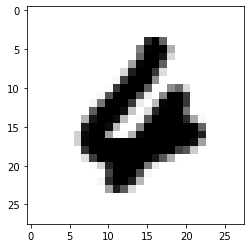



2 [ Predicted Value: 9, Actual Value: 7 ]


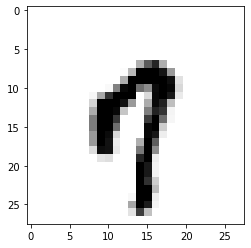



3 [ Predicted Value: 5, Actual Value: 3 ]


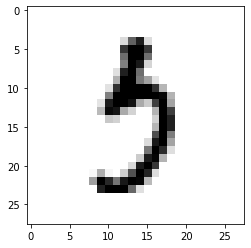



4 [ Predicted Value: 4, Actual Value: 9 ]


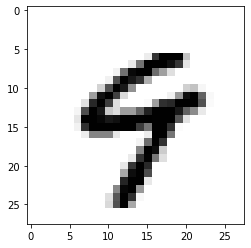



5 [ Predicted Value: 4, Actual Value: 9 ]


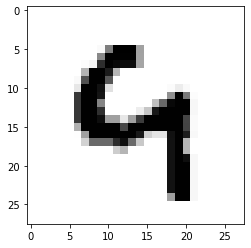



6 [ Predicted Value: 8, Actual Value: 6 ]


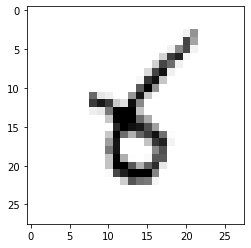



7 [ Predicted Value: 8, Actual Value: 6 ]


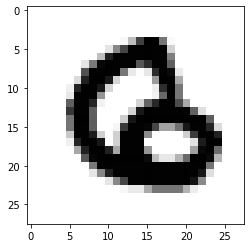



8 [ Predicted Value: 9, Actual Value: 8 ]


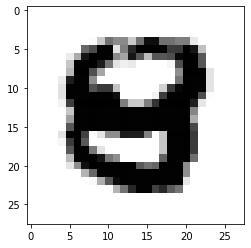



9 [ Predicted Value: 5, Actual Value: 3 ]


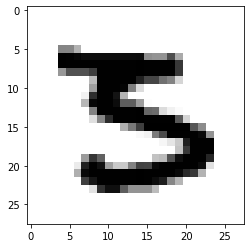



10 [ Predicted Value: 7, Actual Value: 5 ]


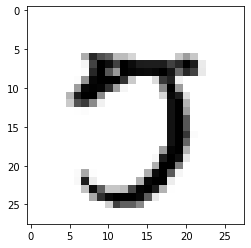



11 [ Predicted Value: 4, Actual Value: 9 ]


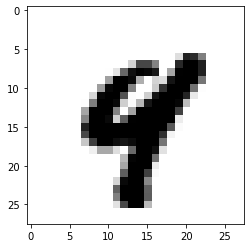



12 [ Predicted Value: 9, Actual Value: 4 ]


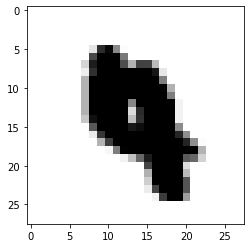



13 [ Predicted Value: 5, Actual Value: 6 ]


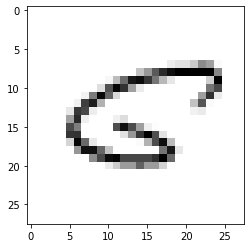



14 [ Predicted Value: 5, Actual Value: 6 ]


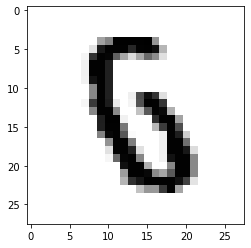



15 [ Predicted Value: 1, Actual Value: 7 ]


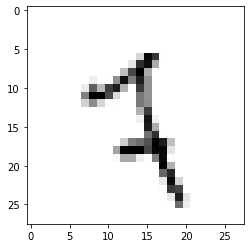



16 [ Predicted Value: 0, Actual Value: 2 ]


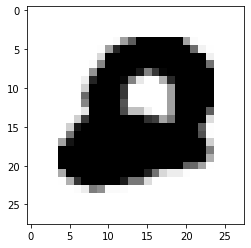



17 [ Predicted Value: 4, Actual Value: 9 ]


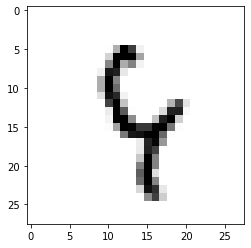



18 [ Predicted Value: 1, Actual Value: 7 ]


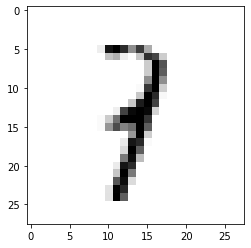



19 [ Predicted Value: 4, Actual Value: 6 ]


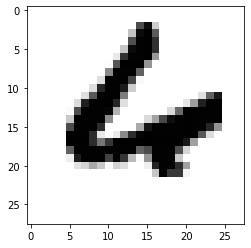



20 [ Predicted Value: 4, Actual Value: 9 ]


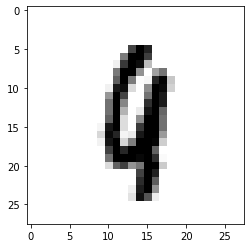



21 [ Predicted Value: 9, Actual Value: 3 ]


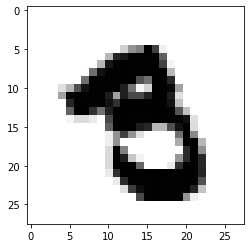



22 [ Predicted Value: 4, Actual Value: 2 ]


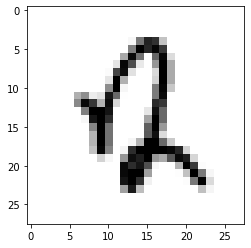



23 [ Predicted Value: 9, Actual Value: 8 ]


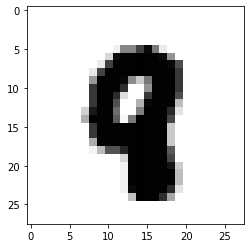



24 [ Predicted Value: 2, Actual Value: 1 ]


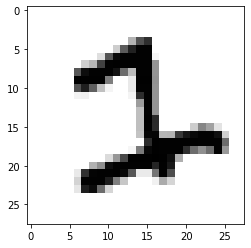



25 [ Predicted Value: 4, Actual Value: 9 ]


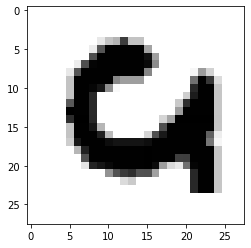



26 [ Predicted Value: 6, Actual Value: 0 ]


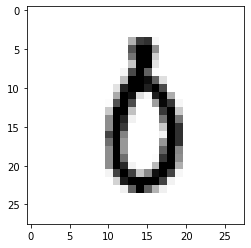



27 [ Predicted Value: 4, Actual Value: 9 ]


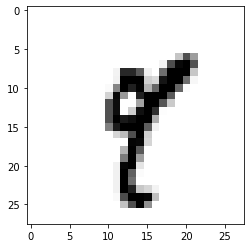



28 [ Predicted Value: 0, Actual Value: 6 ]


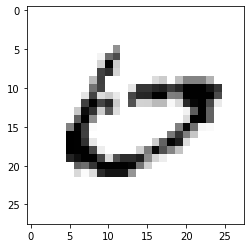



29 [ Predicted Value: 3, Actual Value: 6 ]


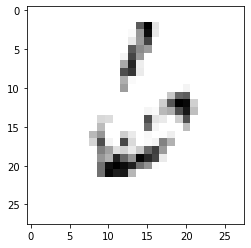



30 [ Predicted Value: 1, Actual Value: 7 ]


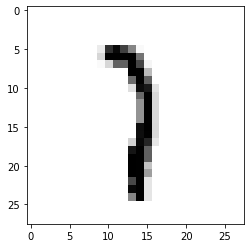



31 [ Predicted Value: 0, Actual Value: 6 ]


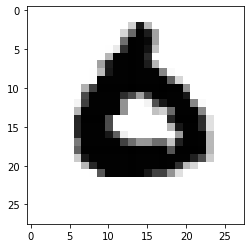



32 [ Predicted Value: 4, Actual Value: 9 ]


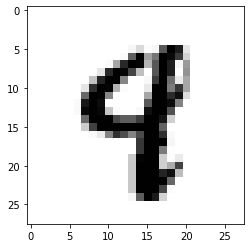



33 [ Predicted Value: 6, Actual Value: 5 ]


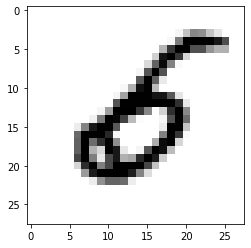



34 [ Predicted Value: 7, Actual Value: 9 ]


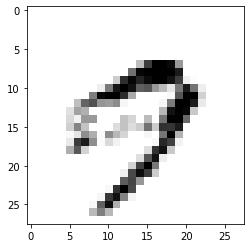



35 [ Predicted Value: 5, Actual Value: 6 ]


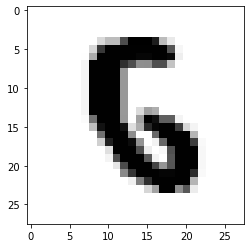



36 [ Predicted Value: 3, Actual Value: 8 ]


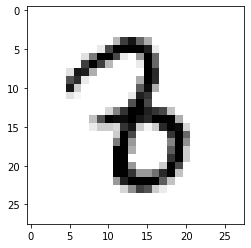



37 [ Predicted Value: 1, Actual Value: 7 ]


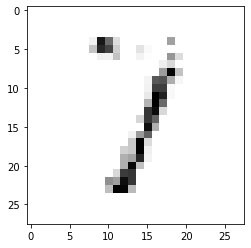



38 [ Predicted Value: 4, Actual Value: 6 ]


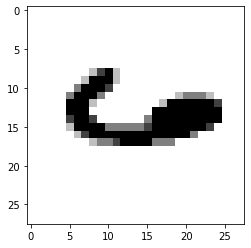



39 [ Predicted Value: 1, Actual Value: 6 ]


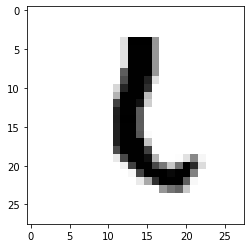



40 [ Predicted Value: 7, Actual Value: 9 ]


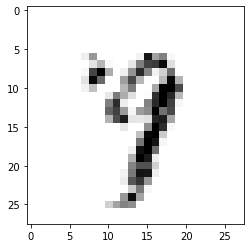



41 [ Predicted Value: 7, Actual Value: 0 ]


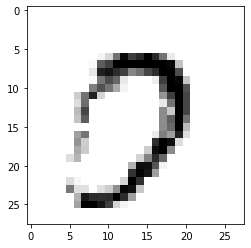



42 [ Predicted Value: 2, Actual Value: 6 ]


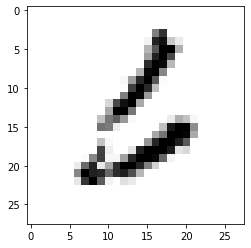



43 [ Predicted Value: 4, Actual Value: 1 ]


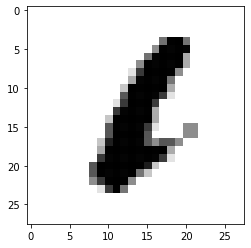



44 [ Predicted Value: 9, Actual Value: 4 ]


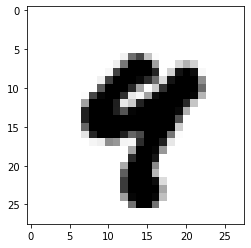



45 [ Predicted Value: 2, Actual Value: 7 ]


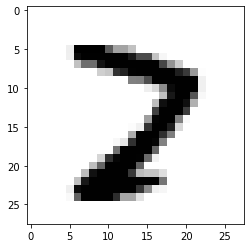



46 [ Predicted Value: 1, Actual Value: 6 ]


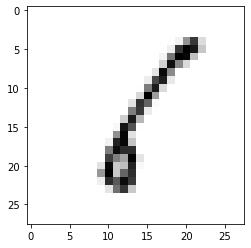



47 [ Predicted Value: 3, Actual Value: 9 ]


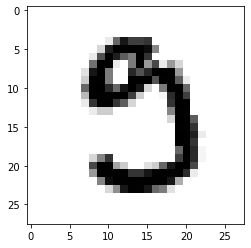



48 [ Predicted Value: 2, Actual Value: 6 ]


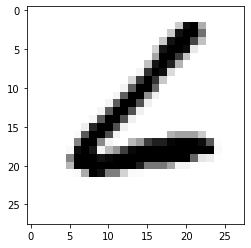



49 [ Predicted Value: 5, Actual Value: 8 ]


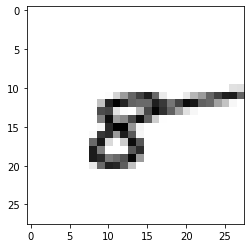



50 [ Predicted Value: 7, Actual Value: 2 ]


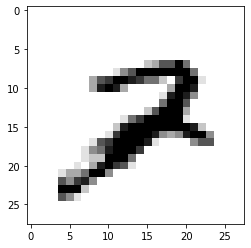



51 [ Predicted Value: 5, Actual Value: 3 ]


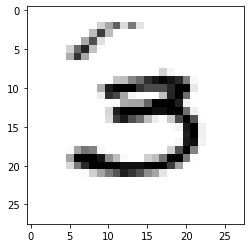



52 [ Predicted Value: 9, Actual Value: 4 ]


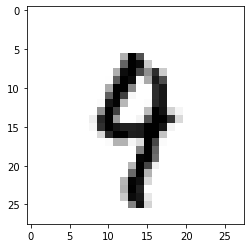



53 [ Predicted Value: 1, Actual Value: 6 ]


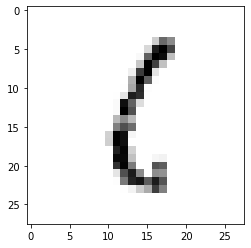



54 [ Predicted Value: 2, Actual Value: 8 ]


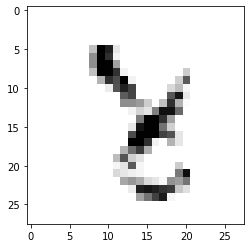



55 [ Predicted Value: 7, Actual Value: 8 ]


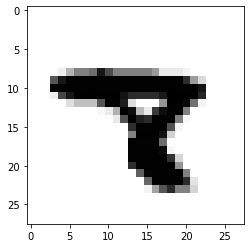



56 [ Predicted Value: 6, Actual Value: 8 ]


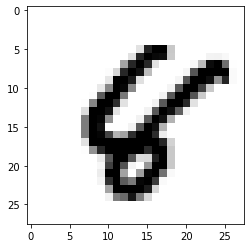



57 [ Predicted Value: 3, Actual Value: 5 ]


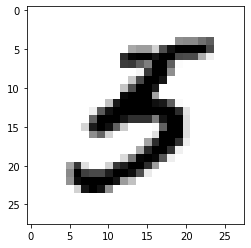



58 [ Predicted Value: 2, Actual Value: 8 ]


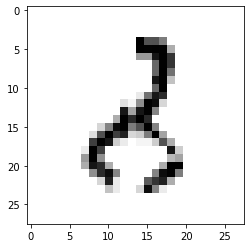



59 [ Predicted Value: 7, Actual Value: 2 ]


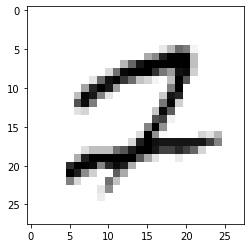



60 [ Predicted Value: 3, Actual Value: 5 ]


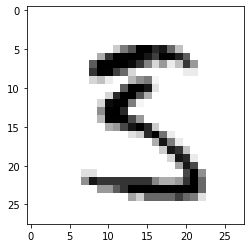



61 [ Predicted Value: 1, Actual Value: 7 ]


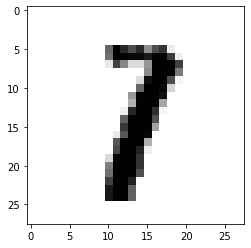



62 [ Predicted Value: 8, Actual Value: 9 ]


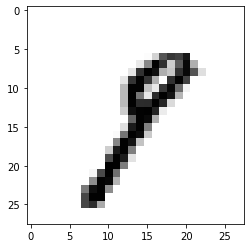

In [15]:
print('\n#########################With L1 Optimisation######################################\n')

train_losses_l1, train_acc_l1, test_losses_l1, test_acc_l1 = trainModel('_l1', L1_Flag =True, L2_Flag = False, alpha = al )


#With L2 Optimisation

  0%|          | 0/469 [00:00<?, ?it/s]


#########################With L2 Optimisation######################################

alpha =  5e-05
EPOCH _l2 0


Loss=0.22155389189720154 Batch_id=468 Accuracy=86.70: 100%|██████████| 469/469 [00:13<00:00, 33.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0866, Accuracy: 9725/10000 (97.25%)

EPOCH _l2 1


Loss=0.11474544554948807 Batch_id=468 Accuracy=97.45: 100%|██████████| 469/469 [00:13<00:00, 34.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0609, Accuracy: 9806/10000 (98.06%)

EPOCH _l2 2


Loss=0.03347255662083626 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:13<00:00, 34.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9854/10000 (98.54%)

EPOCH _l2 3


Loss=0.04756591469049454 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:14<00:00, 32.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9891/10000 (98.91%)

EPOCH _l2 4


Loss=0.07297348231077194 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:13<00:00, 34.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9896/10000 (98.96%)

EPOCH _l2 5


Loss=0.02558750845491886 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:13<00:00, 34.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9905/10000 (99.05%)

EPOCH _l2 6


Loss=0.07777372002601624 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:13<00:00, 35.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9912/10000 (99.12%)

EPOCH _l2 7


Loss=0.02339852601289749 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:14<00:00, 33.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9899/10000 (98.99%)

EPOCH _l2 8


Loss=0.023108994588255882 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:13<00:00, 34.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9916/10000 (99.16%)

EPOCH _l2 9


Loss=0.02241726964712143 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:13<00:00, 43.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9925/10000 (99.25%)

EPOCH _l2 10


Loss=0.06617437303066254 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:13<00:00, 35.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9924/10000 (99.24%)

EPOCH _l2 11


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9923/10000 (99.23%)

EPOCH _l2 12


Loss=0.0755687803030014 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:13<00:00, 34.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9927/10000 (99.27%)

EPOCH _l2 13


Loss=0.03892950713634491 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:13<00:00, 35.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9928/10000 (99.28%)

EPOCH _l2 14


Loss=0.031727828085422516 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:13<00:00, 35.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9929/10000 (99.29%)

EPOCH _l2 15


Loss=0.09475545585155487 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:13<00:00, 34.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9924/10000 (99.24%)

EPOCH _l2 16


Loss=0.0602288693189621 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:13<00:00, 34.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9921/10000 (99.21%)

EPOCH _l2 17


Loss=0.03976842761039734 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 35.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9937/10000 (99.37%)

EPOCH _l2 18


Loss=0.036924149841070175 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:13<00:00, 35.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9931/10000 (99.31%)

EPOCH _l2 19


Loss=0.054949261248111725 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 33.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9931/10000 (99.31%)

EPOCH _l2 20


Loss=0.04613424837589264 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:13<00:00, 35.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9932/10000 (99.32%)

EPOCH _l2 21


Loss=0.053485970944166183 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:12<00:00, 36.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9941/10000 (99.41%)

EPOCH _l2 22


Loss=0.061779797077178955 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:13<00:00, 44.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9940/10000 (99.40%)

EPOCH _l2 23


Loss=0.06558278203010559 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:14<00:00, 33.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9935/10000 (99.35%)

EPOCH _l2 24


Loss=0.070482537150383 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:13<00:00, 34.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9927/10000 (99.27%)

EPOCH _l2 25


Loss=0.06282461434602737 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:13<00:00, 43.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9943/10000 (99.43%)

EPOCH _l2 26


Loss=0.03891340643167496 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 35.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9947/10000 (99.47%)

EPOCH _l2 27


Loss=0.09014125168323517 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 34.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9950/10000 (99.50%)

EPOCH _l2 28


Loss=0.057409051805734634 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:13<00:00, 42.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9942/10000 (99.42%)

EPOCH _l2 29


Loss=0.04113010689616203 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 35.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9942/10000 (99.42%)

EPOCH _l2 30


Loss=0.026431312784552574 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 35.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9941/10000 (99.41%)

EPOCH _l2 31


Loss=0.024237457662820816 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:13<00:00, 35.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 9946/10000 (99.46%)

EPOCH _l2 32


Loss=0.09668762236833572 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 35.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9938/10000 (99.38%)

EPOCH _l2 33


Loss=0.06956011801958084 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:13<00:00, 35.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9949/10000 (99.49%)

EPOCH _l2 34


Loss=0.0729372575879097 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 34.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9944/10000 (99.44%)

EPOCH _l2 35


Loss=0.03208484500646591 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:13<00:00, 34.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9951/10000 (99.51%)

EPOCH _l2 36


Loss=0.052506111562252045 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:13<00:00, 35.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9943/10000 (99.43%)

EPOCH _l2 37


Loss=0.03366124629974365 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:12<00:00, 36.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9944/10000 (99.44%)

EPOCH _l2 38


Loss=0.028603455051779747 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 34.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9940/10000 (99.40%)

EPOCH _l2 39


Loss=0.03434489667415619 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 40.93it/s]



Test set: Average loss: 0.0165, Accuracy: 9943/10000 (99.43%)


@@@@@@@@@@@@@MISCLASSIFIED IMAGES@@@@@@@@@@@@@@@@@@@@@@@@@@@



1 [ Predicted Value: 7, Actual Value: 2 ]


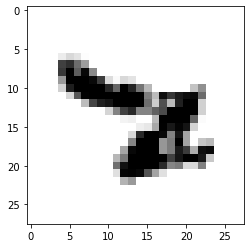



2 [ Predicted Value: 9, Actual Value: 8 ]


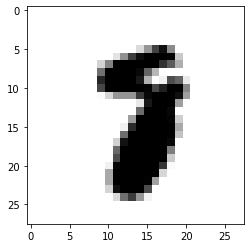



3 [ Predicted Value: 4, Actual Value: 9 ]


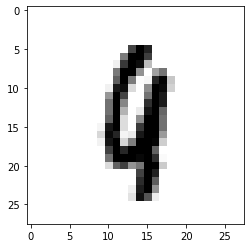



4 [ Predicted Value: 1, Actual Value: 8 ]


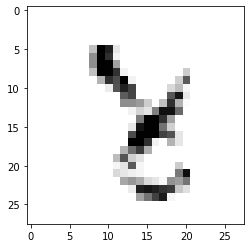



5 [ Predicted Value: 1, Actual Value: 7 ]


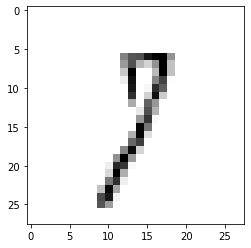



6 [ Predicted Value: 7, Actual Value: 9 ]


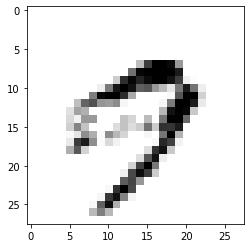



7 [ Predicted Value: 4, Actual Value: 9 ]


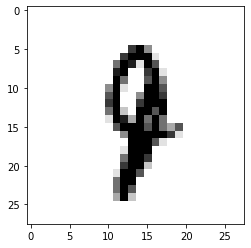



8 [ Predicted Value: 4, Actual Value: 9 ]


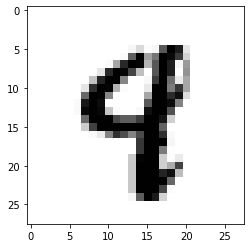



9 [ Predicted Value: 0, Actual Value: 5 ]


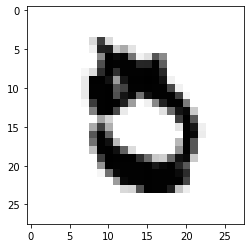



10 [ Predicted Value: 4, Actual Value: 9 ]


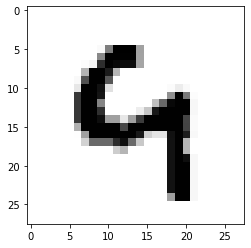



11 [ Predicted Value: 7, Actual Value: 8 ]


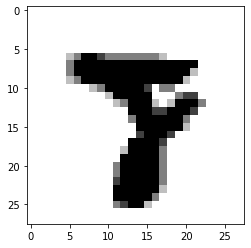



12 [ Predicted Value: 7, Actual Value: 8 ]


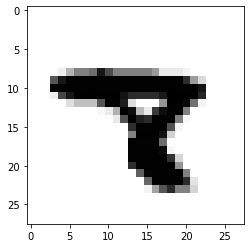



13 [ Predicted Value: 5, Actual Value: 6 ]


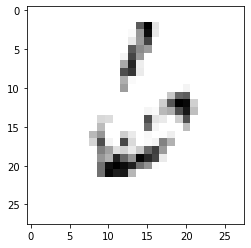



14 [ Predicted Value: 0, Actual Value: 6 ]


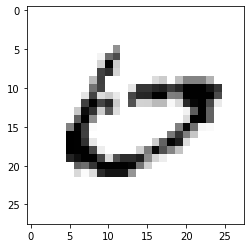



15 [ Predicted Value: 1, Actual Value: 6 ]


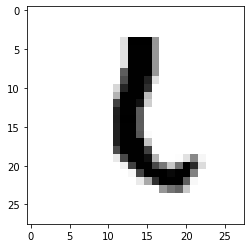



16 [ Predicted Value: 4, Actual Value: 9 ]


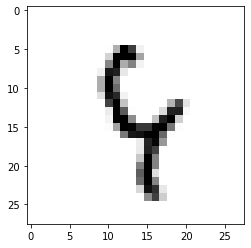



17 [ Predicted Value: 7, Actual Value: 9 ]


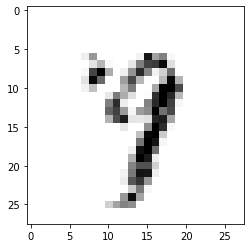



18 [ Predicted Value: 9, Actual Value: 8 ]


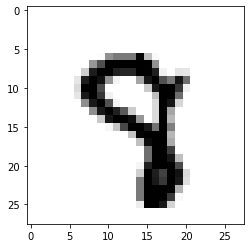



19 [ Predicted Value: 3, Actual Value: 8 ]


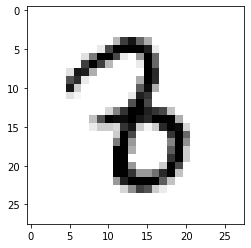



20 [ Predicted Value: 2, Actual Value: 7 ]


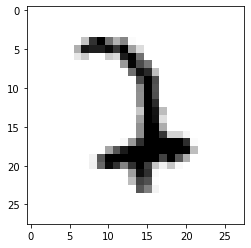



21 [ Predicted Value: 7, Actual Value: 2 ]


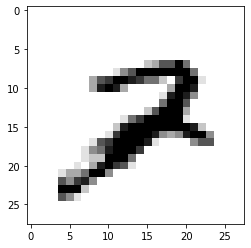



22 [ Predicted Value: 1, Actual Value: 7 ]


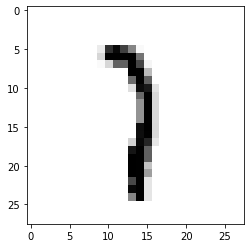



23 [ Predicted Value: 9, Actual Value: 8 ]


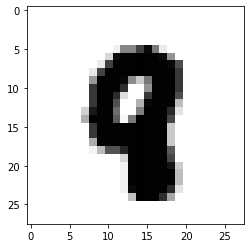



24 [ Predicted Value: 2, Actual Value: 0 ]


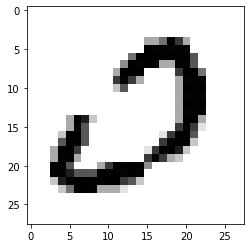



25 [ Predicted Value: 0, Actual Value: 6 ]


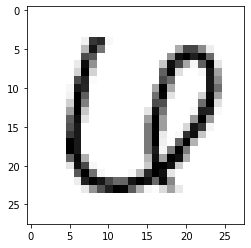



26 [ Predicted Value: 7, Actual Value: 2 ]


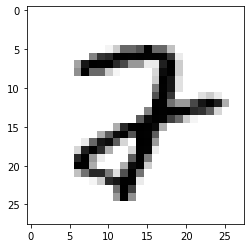



27 [ Predicted Value: 6, Actual Value: 5 ]


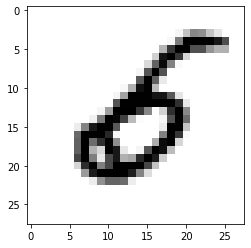



28 [ Predicted Value: 0, Actual Value: 6 ]


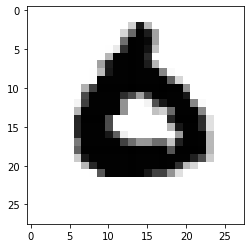



29 [ Predicted Value: 0, Actual Value: 6 ]


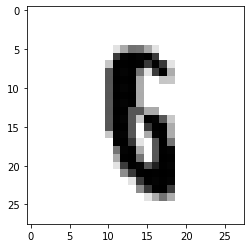



30 [ Predicted Value: 5, Actual Value: 3 ]


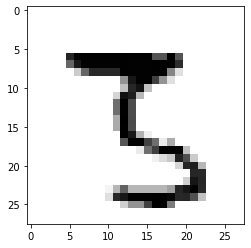



31 [ Predicted Value: 1, Actual Value: 6 ]


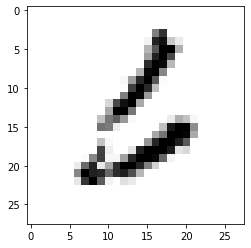



32 [ Predicted Value: 1, Actual Value: 6 ]


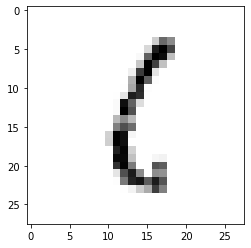



33 [ Predicted Value: 0, Actual Value: 8 ]


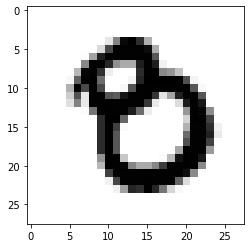



34 [ Predicted Value: 2, Actual Value: 3 ]


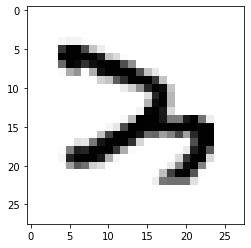



35 [ Predicted Value: 5, Actual Value: 6 ]


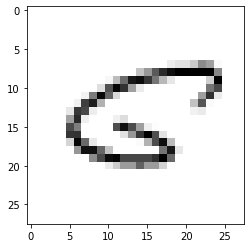



36 [ Predicted Value: 1, Actual Value: 7 ]


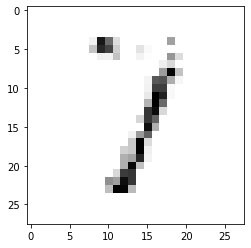



37 [ Predicted Value: 5, Actual Value: 8 ]


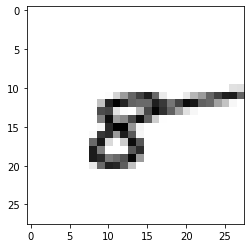



38 [ Predicted Value: 6, Actual Value: 2 ]


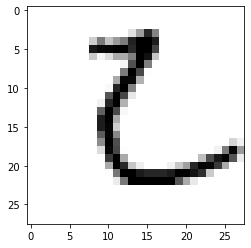



39 [ Predicted Value: 5, Actual Value: 9 ]


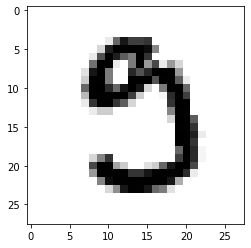



40 [ Predicted Value: 3, Actual Value: 5 ]


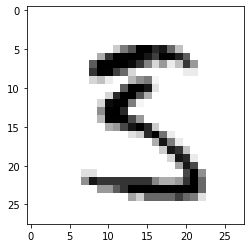



41 [ Predicted Value: 6, Actual Value: 9 ]


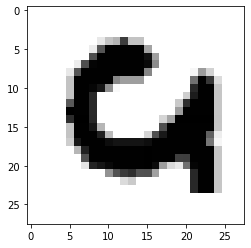



42 [ Predicted Value: 7, Actual Value: 2 ]


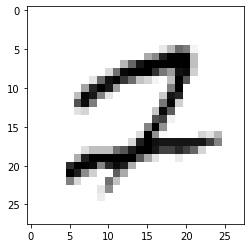



43 [ Predicted Value: 1, Actual Value: 7 ]


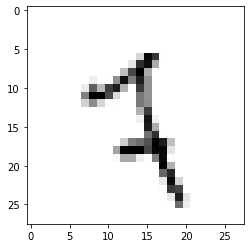



44 [ Predicted Value: 5, Actual Value: 9 ]


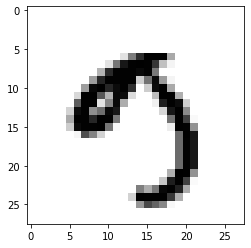



45 [ Predicted Value: 2, Actual Value: 1 ]


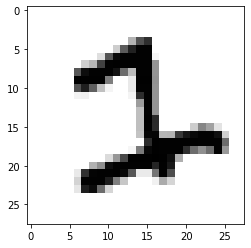



46 [ Predicted Value: 2, Actual Value: 8 ]


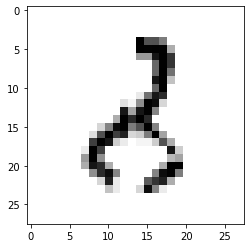



47 [ Predicted Value: 5, Actual Value: 1 ]


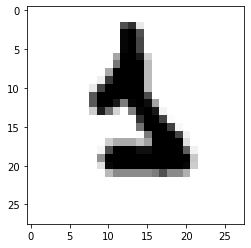



48 [ Predicted Value: 9, Actual Value: 4 ]


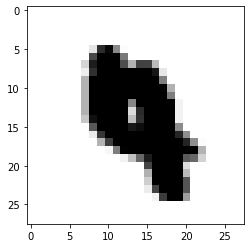



49 [ Predicted Value: 4, Actual Value: 9 ]


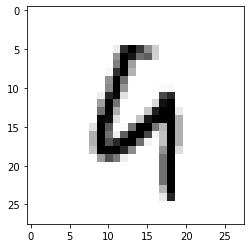



50 [ Predicted Value: 4, Actual Value: 9 ]


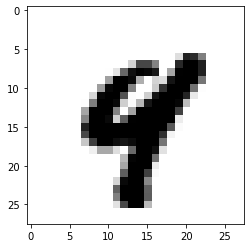



51 [ Predicted Value: 0, Actual Value: 2 ]


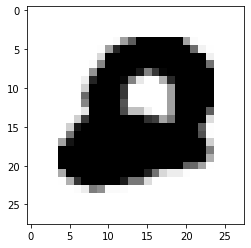



52 [ Predicted Value: 9, Actual Value: 4 ]


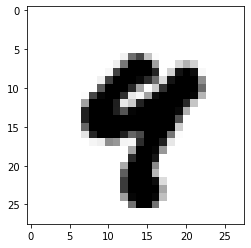



53 [ Predicted Value: 5, Actual Value: 3 ]


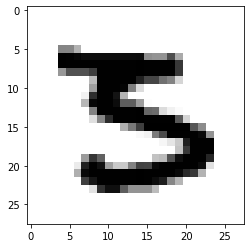



54 [ Predicted Value: 7, Actual Value: 0 ]


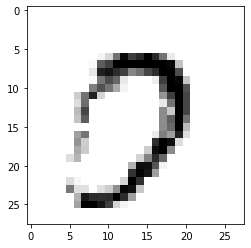



55 [ Predicted Value: 2, Actual Value: 7 ]


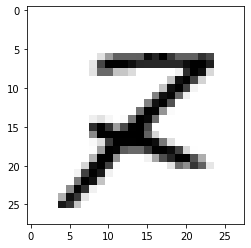



56 [ Predicted Value: 0, Actual Value: 6 ]


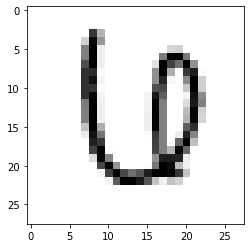



57 [ Predicted Value: 4, Actual Value: 6 ]


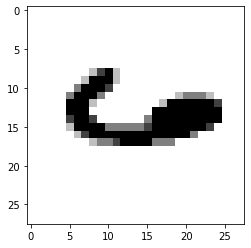

In [16]:
print('\n#########################With L2 Optimisation######################################\n')

train_losses_l2, train_acc_l2, test_losses_l2, test_acc_l2 = trainModel('_l2', L1_Flag =False, L2_Flag = True, alpha = al )

#With Both L1 and L2 Optimisations

  0%|          | 0/469 [00:00<?, ?it/s]


################With Both L1 and L2 Optimisations##################################

alpha =  5e-05
EPOCH _l1_l2 0


Loss=0.1552242636680603 Batch_id=468 Accuracy=87.12: 100%|██████████| 469/469 [00:13<00:00, 34.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0815, Accuracy: 9757/10000 (97.57%)

EPOCH _l1_l2 1


Loss=0.18353019654750824 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:14<00:00, 33.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9875/10000 (98.75%)

EPOCH _l1_l2 2


Loss=0.17631486058235168 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:14<00:00, 32.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9892/10000 (98.92%)

EPOCH _l1_l2 3


Loss=0.14086750149726868 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:14<00:00, 32.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9896/10000 (98.96%)

EPOCH _l1_l2 4


Loss=0.12740325927734375 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:13<00:00, 34.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9917/10000 (99.17%)

EPOCH _l1_l2 5


Loss=0.12591980397701263 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:14<00:00, 32.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9899/10000 (98.99%)

EPOCH _l1_l2 6


Loss=0.07885182648897171 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:13<00:00, 35.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9923/10000 (99.23%)

EPOCH _l1_l2 7


Loss=0.12441354990005493 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:14<00:00, 32.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9912/10000 (99.12%)

EPOCH _l1_l2 8


Loss=0.14984837174415588 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:14<00:00, 33.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9922/10000 (99.22%)

EPOCH _l1_l2 9


Loss=0.06822574883699417 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:14<00:00, 32.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9925/10000 (99.25%)

EPOCH _l1_l2 10


Loss=0.09446297585964203 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:14<00:00, 33.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9924/10000 (99.24%)

EPOCH _l1_l2 11


Loss=0.08106645941734314 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:14<00:00, 32.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9911/10000 (99.11%)

EPOCH _l1_l2 12


Loss=0.29525184631347656 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:13<00:00, 33.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9926/10000 (99.26%)

EPOCH _l1_l2 13


Loss=0.1879551112651825 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 39.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9920/10000 (99.20%)

EPOCH _l1_l2 14


Loss=0.08700128644704819 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:14<00:00, 35.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9927/10000 (99.27%)

EPOCH _l1_l2 15


Loss=0.1621190905570984 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 33.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9922/10000 (99.22%)

EPOCH _l1_l2 16


Loss=0.09034881740808487 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:14<00:00, 32.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9922/10000 (99.22%)

EPOCH _l1_l2 17


Loss=0.16711682081222534 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:13<00:00, 33.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9937/10000 (99.37%)

EPOCH _l1_l2 18


Loss=0.12251140922307968 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 32.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9938/10000 (99.38%)

EPOCH _l1_l2 19


Loss=0.09074698388576508 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 33.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9925/10000 (99.25%)

EPOCH _l1_l2 20


Loss=0.07994747161865234 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:14<00:00, 33.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9934/10000 (99.34%)

EPOCH _l1_l2 21


Loss=0.07998799532651901 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:14<00:00, 33.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9925/10000 (99.25%)

EPOCH _l1_l2 22


Loss=0.0894186720252037 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:14<00:00, 32.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9938/10000 (99.38%)

EPOCH _l1_l2 23


Loss=0.08528771251440048 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:13<00:00, 33.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9934/10000 (99.34%)

EPOCH _l1_l2 24


Loss=0.08836666494607925 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:14<00:00, 33.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9936/10000 (99.36%)

EPOCH _l1_l2 25


Loss=0.11078028380870819 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:14<00:00, 41.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9940/10000 (99.40%)

EPOCH _l1_l2 26


Loss=0.09699474275112152 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:14<00:00, 33.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9941/10000 (99.41%)

EPOCH _l1_l2 27


Loss=0.14479416608810425 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 33.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9936/10000 (99.36%)

EPOCH _l1_l2 28


Loss=0.09047465771436691 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:14<00:00, 31.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9943/10000 (99.43%)

EPOCH _l1_l2 29


Loss=0.08575776219367981 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:13<00:00, 33.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9939/10000 (99.39%)

EPOCH _l1_l2 30


Loss=0.20137912034988403 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:14<00:00, 33.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9938/10000 (99.38%)

EPOCH _l1_l2 31


Loss=0.11647924780845642 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 34.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9933/10000 (99.33%)

EPOCH _l1_l2 32


Loss=0.08927847445011139 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 33.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9942/10000 (99.42%)

EPOCH _l1_l2 33


Loss=0.10113847255706787 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:13<00:00, 35.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9946/10000 (99.46%)

EPOCH _l1_l2 34


Loss=0.17460080981254578 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 33.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9942/10000 (99.42%)

EPOCH _l1_l2 35


Loss=0.1223350465297699 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 35.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9939/10000 (99.39%)

EPOCH _l1_l2 36


Loss=0.08893386274576187 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 34.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9934/10000 (99.34%)

EPOCH _l1_l2 37


Loss=0.11732441931962967 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:13<00:00, 34.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9947/10000 (99.47%)

EPOCH _l1_l2 38


Loss=0.09036019444465637 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:14<00:00, 33.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9943/10000 (99.43%)

EPOCH _l1_l2 39


Loss=0.12901172041893005 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:13<00:00, 34.03it/s]



Test set: Average loss: 0.0179, Accuracy: 9950/10000 (99.50%)


@@@@@@@@@@@@@MISCLASSIFIED IMAGES@@@@@@@@@@@@@@@@@@@@@@@@@@@



1 [ Predicted Value: 1, Actual Value: 6 ]


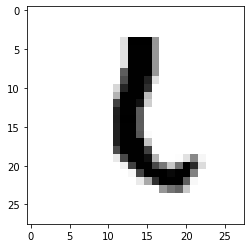



2 [ Predicted Value: 1, Actual Value: 9 ]


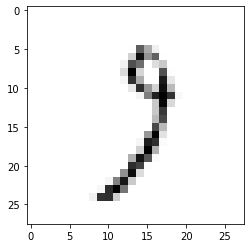



3 [ Predicted Value: 0, Actual Value: 6 ]


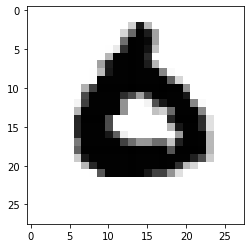



4 [ Predicted Value: 2, Actual Value: 7 ]


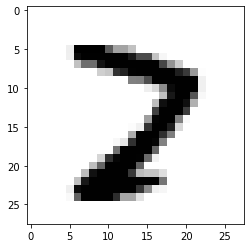



5 [ Predicted Value: 1, Actual Value: 8 ]


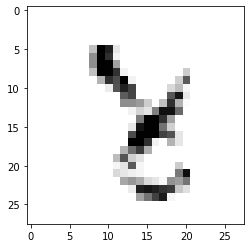



6 [ Predicted Value: 3, Actual Value: 5 ]


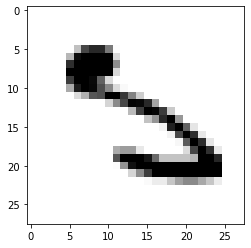



7 [ Predicted Value: 5, Actual Value: 9 ]


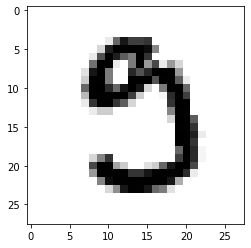



8 [ Predicted Value: 2, Actual Value: 7 ]


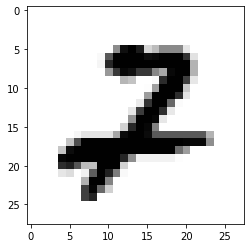



9 [ Predicted Value: 1, Actual Value: 9 ]


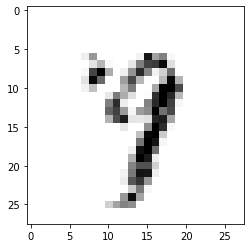



10 [ Predicted Value: 0, Actual Value: 2 ]


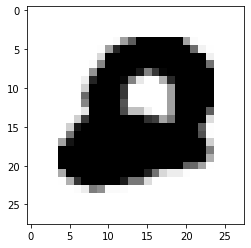



11 [ Predicted Value: 2, Actual Value: 3 ]


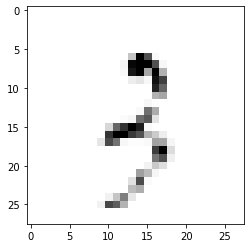



12 [ Predicted Value: 9, Actual Value: 4 ]


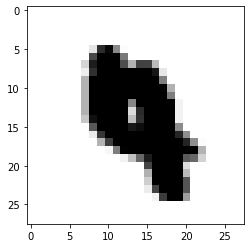



13 [ Predicted Value: 2, Actual Value: 7 ]


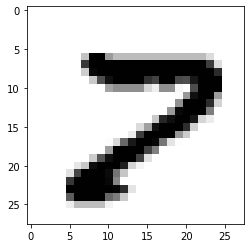



14 [ Predicted Value: 4, Actual Value: 6 ]


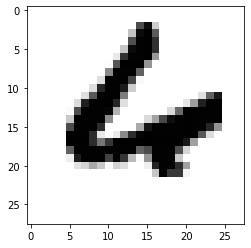



15 [ Predicted Value: 1, Actual Value: 6 ]


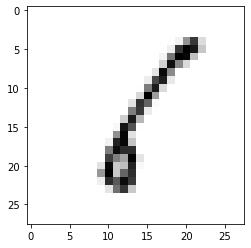



16 [ Predicted Value: 3, Actual Value: 5 ]


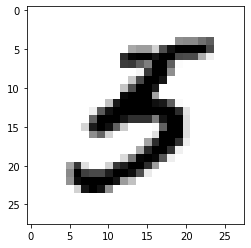



17 [ Predicted Value: 7, Actual Value: 9 ]


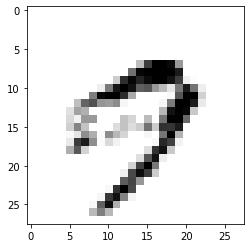



18 [ Predicted Value: 2, Actual Value: 7 ]


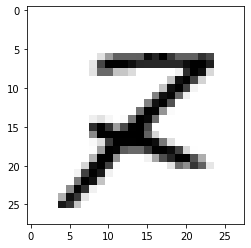



19 [ Predicted Value: 1, Actual Value: 6 ]


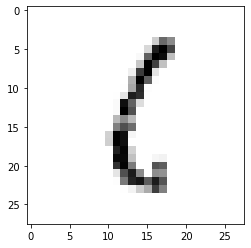



20 [ Predicted Value: 1, Actual Value: 6 ]


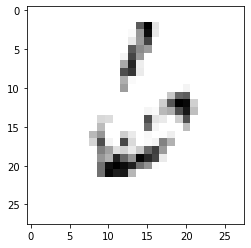



21 [ Predicted Value: 4, Actual Value: 6 ]


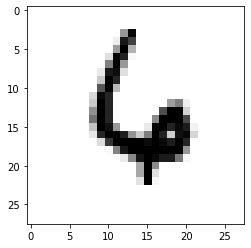



22 [ Predicted Value: 3, Actual Value: 5 ]


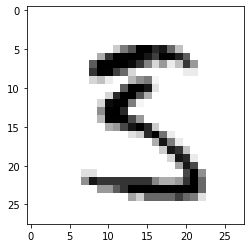



23 [ Predicted Value: 5, Actual Value: 3 ]


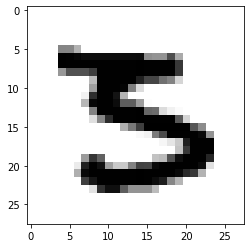



24 [ Predicted Value: 7, Actual Value: 9 ]


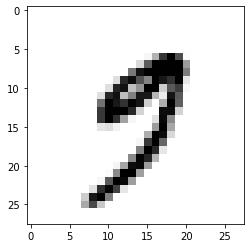



25 [ Predicted Value: 9, Actual Value: 4 ]


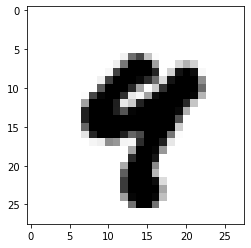



26 [ Predicted Value: 6, Actual Value: 5 ]


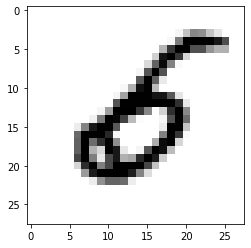



27 [ Predicted Value: 2, Actual Value: 3 ]


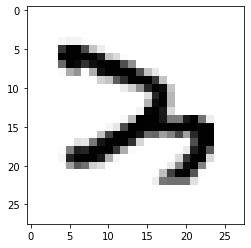



28 [ Predicted Value: 1, Actual Value: 7 ]


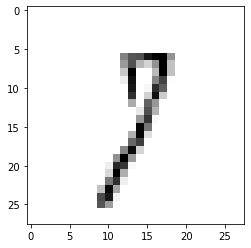



29 [ Predicted Value: 1, Actual Value: 3 ]


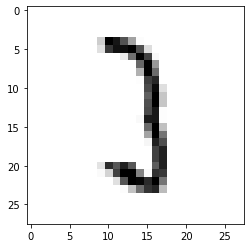



30 [ Predicted Value: 5, Actual Value: 8 ]


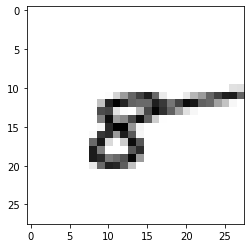



31 [ Predicted Value: 4, Actual Value: 6 ]


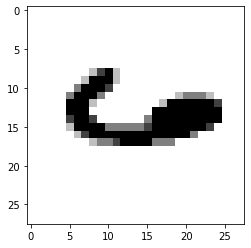



32 [ Predicted Value: 9, Actual Value: 8 ]


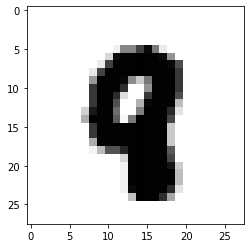



33 [ Predicted Value: 3, Actual Value: 8 ]


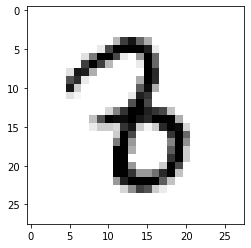



34 [ Predicted Value: 1, Actual Value: 7 ]


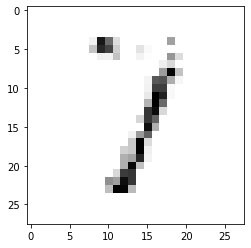



35 [ Predicted Value: 1, Actual Value: 7 ]


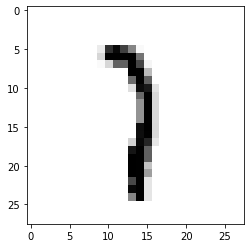



36 [ Predicted Value: 7, Actual Value: 8 ]


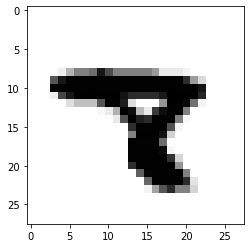



37 [ Predicted Value: 1, Actual Value: 2 ]


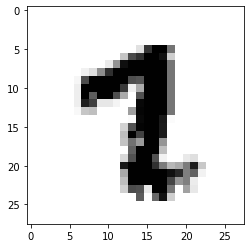



38 [ Predicted Value: 5, Actual Value: 3 ]


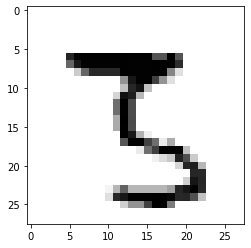



39 [ Predicted Value: 1, Actual Value: 2 ]


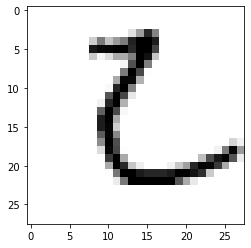



40 [ Predicted Value: 0, Actual Value: 6 ]


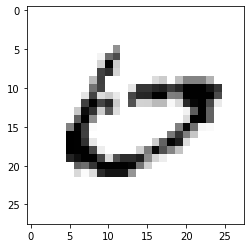



41 [ Predicted Value: 4, Actual Value: 9 ]


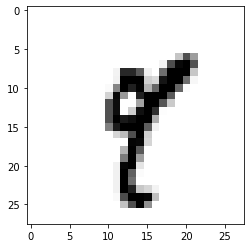



42 [ Predicted Value: 1, Actual Value: 7 ]


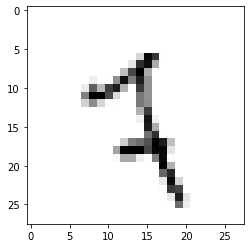



43 [ Predicted Value: 3, Actual Value: 5 ]


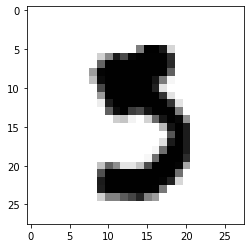



44 [ Predicted Value: 2, Actual Value: 7 ]


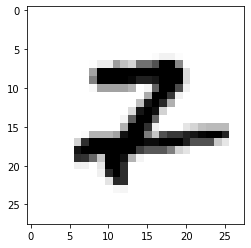



45 [ Predicted Value: 5, Actual Value: 3 ]


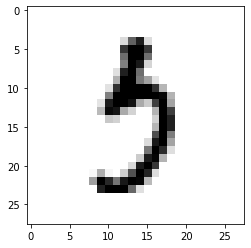



46 [ Predicted Value: 2, Actual Value: 7 ]


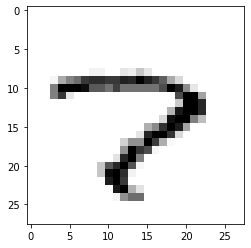



47 [ Predicted Value: 5, Actual Value: 3 ]


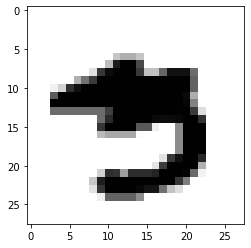



48 [ Predicted Value: 2, Actual Value: 8 ]


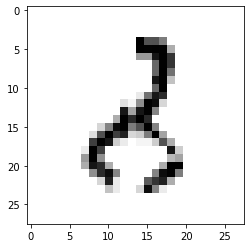



49 [ Predicted Value: 7, Actual Value: 9 ]


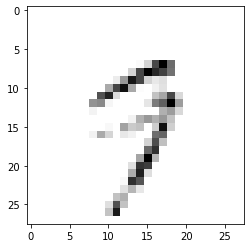



50 [ Predicted Value: 4, Actual Value: 9 ]


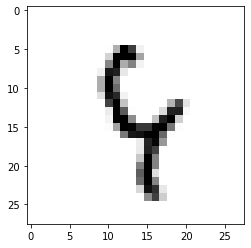

In [17]:
print('\n################With Both L1 and L2 Optimisations##################################\n')

train_losses_l1_l2, train_acc_l1_l2, test_losses_l1_l2, test_acc_l1_l2 = trainModel('_l1_l2', L1_Flag =True, L2_Flag = True, alpha = al )


#Validation Accuracy and Loss Plots


*****************Test Plots for lambda = 5e-05*********************



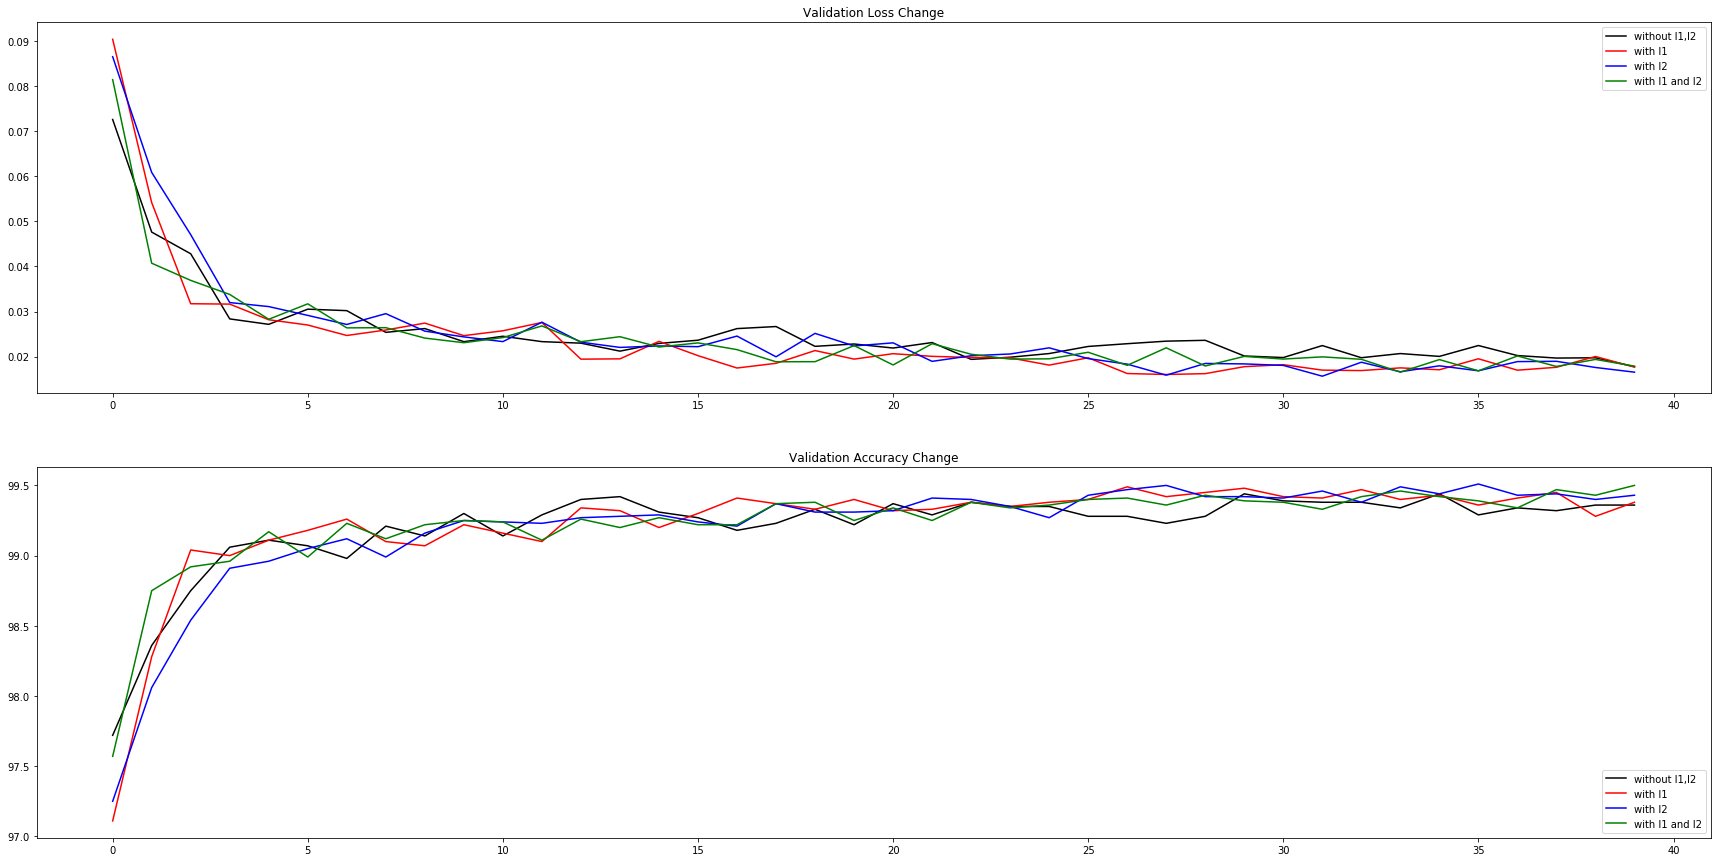

In [28]:

print('\n*****************Test Plots for lambda = {}*********************\n'.format(al))
plotGraphsTest(test_losses_0, test_losses_l1, test_losses_l2, test_losses_l1_l2, test_acc_0, test_acc_l1, test_acc_l2, test_acc_l1_l2)

#Test Accuracy and Loss Plot


*****************Train Plots for lambda = 5e-05*********************



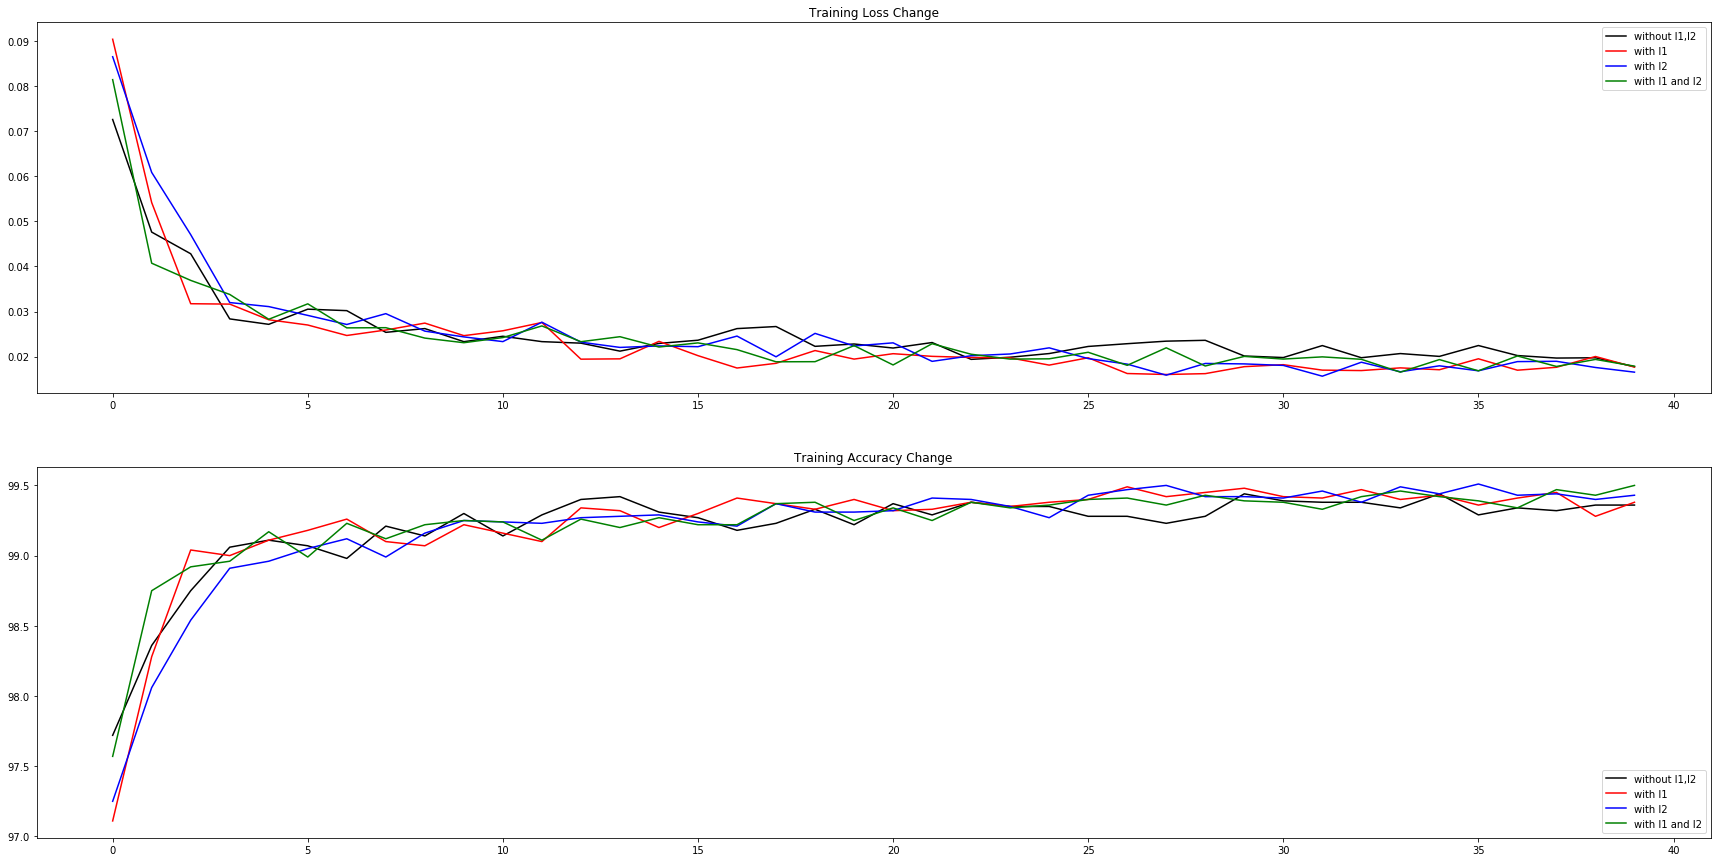

In [29]:
print('\n*****************Train Plots for lambda = {}*********************\n'.format(al))
plotGraphsTrain(train_losses_0, train_losses_l1, train_losses_l2, train_losses_l1_l2, train_acc_0, train_acc_l1, train_acc_l2, train_acc_l1_l2)